# Machine Learning Experiment - Exploratory Data Analysis
# Comprehensive performance comparison across multiple models and folds

## Setup and Imports

In [1]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import List, Dict, Tuple, Union
import re
import os

warnings.filterwarnings('ignore')

# Set style for professional, modern visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Show all rows
pd.set_option("display.max_rows", 1000)

# Show all columns
pd.set_option("display.max_columns", 27)

# Create output directory for images
output_dir = Path("results/images/baselines")
output_dir.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete - Ready for analysis")

# Define color palette
COLORS = {
    "red": "#c94c4c",
    "orange": "#cf8532",
    "purple": "#786797",
    "gray": "#363636",
    "blue": "#406c80",
    "green": "#2B6327",
}

## Data Loading Functions

def load_fold_results(model_spec: Union[str, Tuple[str, str]], results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for all folds of a specific model.
    
    Parameters:
    -----------
    model_spec : str or Tuple[str, str]
        Either a model name (str) or a tuple of (model_name, run_code)
        If tuple, only loads results matching the run_code pattern
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all metrics for all folds and classes
    """
    # Parse model specification
    if isinstance(model_spec, tuple):
        model_name, run_code = model_spec
        filter_by_run = True
    else:
        model_name = model_spec
        run_code = None
        filter_by_run = False
    
    val_path = Path(results_dir) / model_name / "val"
    
    if not val_path.exists():
        raise ValueError(f"Validation directory not found: {val_path}")
    
    # Find all result files
    result_files = sorted(val_path.glob("*_results.pt"))
    
    if not result_files:
        raise ValueError(f"No result files found in {val_path}")
    
    # Filter by run_code if specified
    if filter_by_run:
        filtered_files = []
        for file_path in result_files:
            # Check if run_code is in the filename
            if run_code in file_path.name:
                filtered_files.append(file_path)
        
        if not filtered_files:
            raise ValueError(f"No result files found matching run_code '{run_code}' in {val_path}")
        
        result_files = filtered_files
        print(f"   Filtering by run_code: '{run_code}' - Found {len(result_files)} matching files")
    
    all_data = []
    
    for file_path in result_files:
        # Extract fold number from filename
        fold_match = re.search(r'fold(\d+)', file_path.name)
        if not fold_match:
            continue
            
        fold_num = int(fold_match.group(1))
        
        # Load PyTorch file
        result_data = torch.load(file_path, map_location='cpu')
        
        if result_data.get('status') != 'success':
            print(f"⚠️  Warning: Fold {fold_num} status is not 'success'")
            continue
        
        class_logs = result_data.get('class_logs', {})
        
        # Extract per-class metrics
        for key, value in class_logs.items():
            # Parse key: fold{X}/metric_classname or fold{X}/metric_mean
            parts = key.split('/')
            if len(parts) != 2:
                continue
                
            fold_part, metric_part = parts
            
            # Extract metric and class name
            metric_split = metric_part.split('_', 1)
            if len(metric_split) == 2:
                metric_name, class_name = metric_split
            else:
                continue
            
            all_data.append({
                'model': model_name,
                'fold': fold_num,
                'class': class_name,
                'metric': metric_name,
                'value': float(value)
            })
    
    if not all_data:
        raise ValueError(f"No data could be extracted from result files in {val_path}")
    
    df = pd.DataFrame(all_data)
    
    if filter_by_run:
        print(f"✅ Loaded {len(result_files)} folds for model '{model_name}' (run: {run_code})")
    else:
        print(f"✅ Loaded {len(result_files)} folds for model '{model_name}'")
    
    print(f"   Total records: {len(df)} | Classes: {df['class'].nunique()} | Metrics: {df['metric'].nunique()}")
    
    return df


def load_multiple_models(model_specs: List[Union[str, Tuple[str, str]]], results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for multiple models and combine them.
    
    Parameters:
    -----------uv create jupyter venv
    model_specs : List[Union[str, Tuple[str, str]]]
        List of model specifications. Each can be either:
        - A string: model name (loads all runs)
        - A tuple: (model_name, run_code) (loads only specific run)
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all models' metrics
    """
    all_dfs = []
    
    for model_spec in model_specs:
        try:
            df = load_fold_results(model_spec, results_dir)
            all_dfs.append(df)
        except Exception as e:
            model_name = model_spec if isinstance(model_spec, str) else model_spec[0]
            print(f"❌ Error loading model '{model_name}': {e}")
            continue
    
    if not all_dfs:
        raise ValueError("No models could be loaded successfully")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n{'='*60}")
    print(f"📊 DATASET SUMMARY")
    print(f"{'='*60}")
    print(f"Models loaded: {len(all_dfs)}")
    print(f"Total records: {len(combined_df)}")
    print(f"Folds per model: {combined_df.groupby('model')['fold'].nunique().to_dict()}")
    print(f"{'='*60}\n")
    
    return combined_df


## Example Usage - Load Your Models

# FasterRCNN-ResNet50  images  MobileNetv3-SSD320  prova  VGG16-SSD300  YOLOv11n  YOLOv11s  YOLOv8n

# Specify your model names (directory names in results/)
MODEL_NAMES = [
    "FasterRCNN-ResNet50",
    "MobileNetv3-SSD320",
    "VGG16-SSD300",
    "YOLOv8n",
    ("YOLOv11n", "sa6u00f0"),
    ("YOLOv11s", "2g8l9vlt")
]

# Load data
# Uncomment and modify the following line with your actual model names:
df = load_multiple_models(MODEL_NAMES)

✅ Setup complete - Ready for analysis
✅ Loaded 4 folds for model 'FasterRCNN-ResNet50'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'MobileNetv3-SSD320'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'VGG16-SSD300'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'YOLOv8n'
   Total records: 56 | Classes: 4 | Metrics: 5
   Filtering by run_code: 'sa6u00f0' - Found 4 matching files
✅ Loaded 4 folds for model 'YOLOv11n' (run: sa6u00f0)
   Total records: 96 | Classes: 4 | Metrics: 7
   Filtering by run_code: '2g8l9vlt' - Found 4 matching files
✅ Loaded 4 folds for model 'YOLOv11s' (run: 2g8l9vlt)
   Total records: 96 | Classes: 4 | Metrics: 7

📊 DATASET SUMMARY
Models loaded: 6
Total records: 416
Folds per model: {'FasterRCNN-ResNet50': 4, 'MobileNetv3-SSD320': 4, 'VGG16-SSD300': 4, 'YOLOv11n': 4, 'YOLOv11s': 4, 'YOLOv8n': 4}



In [2]:
# Rinomina ap50 -> mAP50 e ap75 -> mAP75 solo per class='mean' nei modelli YOLOv11
mask = (df['class'] == 'mean') & (df['model'].str.contains('YOLOv11'))
df.loc[mask & (df['metric'] == 'ap50'), 'metric'] = 'mAP50'
df.loc[mask & (df['metric'] == 'ap75'), 'metric'] = 'mAP75'

# Verifica il risultato
print(df[(df['class'] == 'mean') & (df['model'].str.contains('YOLOv11'))]['metric'].unique())

['precision' 'recall' 'f1' 'mAP50' 'mAP75' 'map']


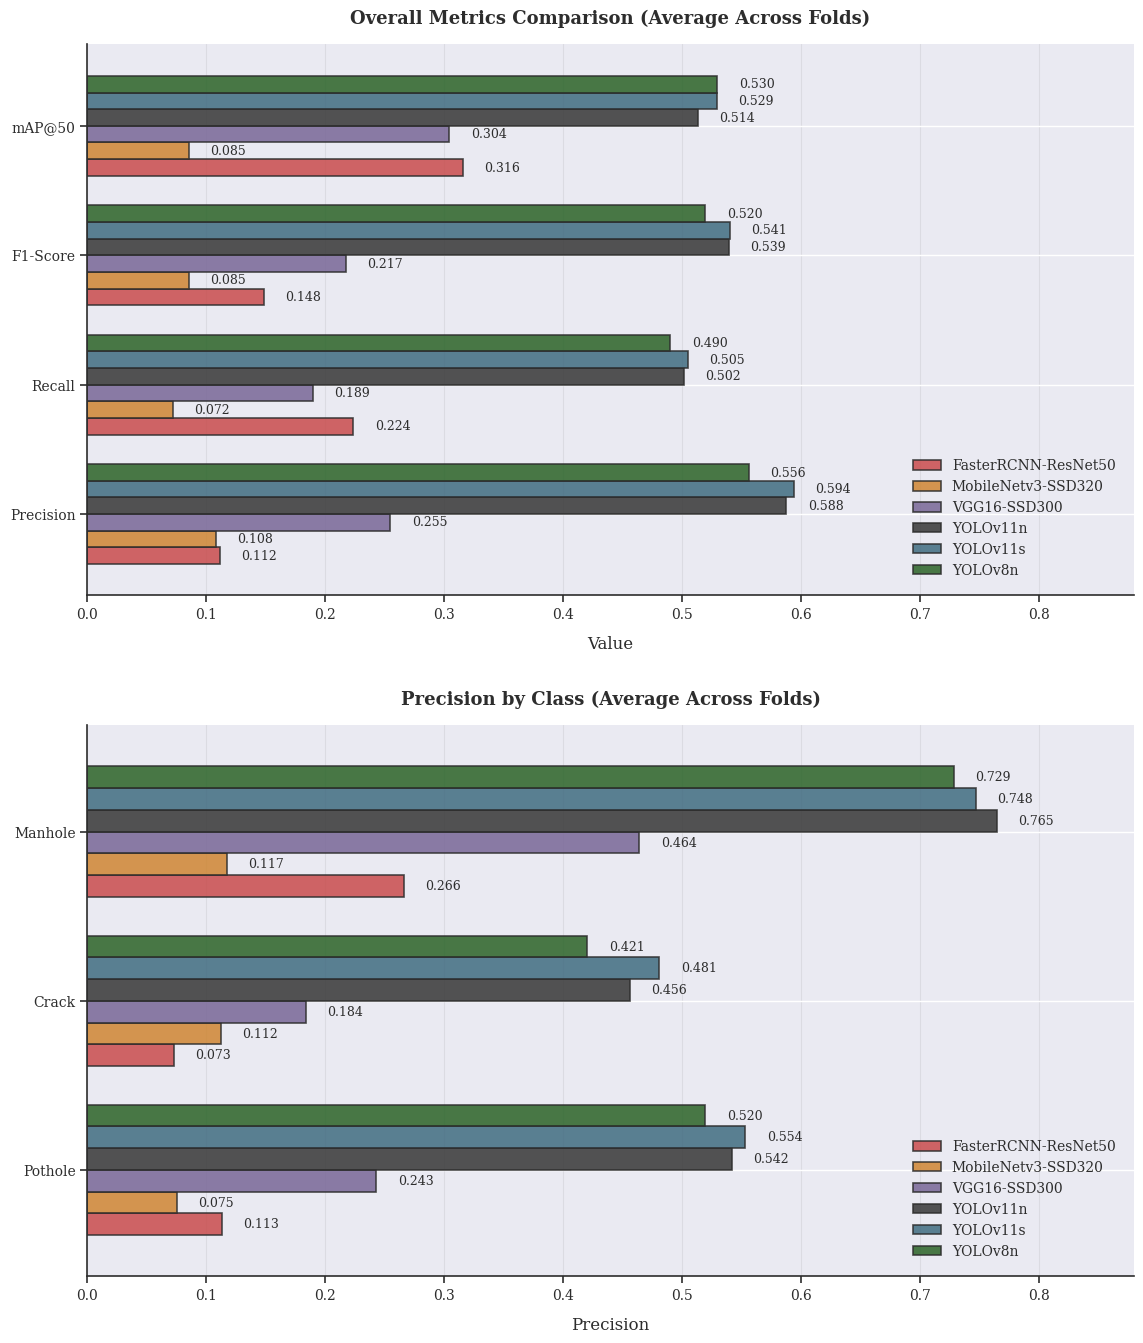

In [17]:
# Aggrega i dati calcolando la media tra tutti i fold
# Per le metriche complessive, usa solo i valori già calcolati con class='mean'
df_mean = df[df['class'] == 'mean'].groupby(['model', 'metric'])['value'].mean().reset_index()

# Per le classi, ESCLUDI 'mean' e calcola la media tra i fold
df_classes = df[df['class'].isin(['pothole', 'crack', 'manhole'])].groupby(['model', 'class', 'metric'])['value'].mean().reset_index()

models = df_mean['model'].unique()

# Usa i colori originali dal dict COLORS
model_colors = {}
color_list = list(COLORS.values())
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

# Crea la figura con due subplot verticali
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
fig.patch.set_facecolor('white')

# ============== SUBPLOT 1: Metriche complessive ==============
map_metric = 'mAP50' if 'mAP50' in df_mean['metric'].values else 'ap50'
metrics = ['precision', 'recall', 'f1', map_metric]

# Aumenta molto la spaziatura tra le metriche
y_pos = np.arange(len(metrics)) * 3.5
bar_height = 0.45
offset = np.linspace(-(len(models)-1)*bar_height/2, (len(models)-1)*bar_height/2, len(models))

for i, model in enumerate(models):
    values = []
    for metric in metrics:
        val = df_mean[(df_mean['model'] == model) & (df_mean['metric'] == metric)]['value'].values
        values.append(val[0] if len(val) > 0 else 0)
    
    bars = ax1.barh(
        y_pos + offset[i],
        values, 
        bar_height,
        label=model,
        color=model_colors[model],
        alpha=0.85,
        edgecolor='#2d2d2d',
        linewidth=1.2
    )
    
    # Valori sulle barre con stile scientifico
    for bar, value in zip(bars, values):
        if value > 0:
            ax1.text(
                bar.get_width() + 0.018,
                bar.get_y() + bar.get_height()/2,
                f'{value:.3f}',
                va='center',
                ha='left',
                fontsize=9,
                fontweight='500',
                color='#2d2d2d',
                fontfamily='serif'
            )

ax1.set_yticks(y_pos)
ax1.set_yticklabels(['Precision', 'Recall', 'F1-Score', 'mAP@50'], 
                     fontsize=11, fontweight='500', fontfamily='serif')
ax1.set_xlabel('Value', fontsize=12, fontweight='500', color='#2d2d2d', 
               fontfamily='serif', labelpad=10)
ax1.set_title('Overall Metrics Comparison (Average Across Folds)', 
              fontsize=13, fontweight='600', pad=15, color='#2d2d2d', fontfamily='serif')

# Legenda elegante
legend1 = ax1.legend(loc='lower right', fontsize=10, framealpha=0.95, 
                     edgecolor='#2d2d2d', borderpad=0.8, fancybox=False)
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_linewidth(1.2)
for text in legend1.get_texts():
    text.set_fontfamily('serif')
    text.set_color('#2d2d2d')

ax1.grid(axis='x', alpha=0.15, linestyle='-', linewidth=0.8, color='#888888')
ax1.set_xlim(0, 0.88)
ax1.set_ylim(-2.2, y_pos[-1] + 2.2)
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.2)
ax1.spines['bottom'].set_linewidth(1.2)
ax1.spines['left'].set_color('#2d2d2d')
ax1.spines['bottom'].set_color('#2d2d2d')
ax1.tick_params(colors='#2d2d2d', labelsize=10, width=1.2, length=5)
for label in ax1.get_xticklabels():
    label.set_fontfamily('serif')

# ============== SUBPLOT 2: Precision per classe ==============
classes = ['pothole', 'crack', 'manhole']
df_precision = df_classes[df_classes['metric'] == 'precision'].copy()

# Aumenta molto la spaziatura tra le classi
y_pos_class = np.arange(len(classes)) * 3.5
offset_class = np.linspace(-(len(models)-1)*bar_height/2, (len(models)-1)*bar_height/2, len(models))

for i, model in enumerate(models):
    values = []
    for cls in classes:
        val = df_precision[(df_precision['model'] == model) & (df_precision['class'] == cls)]['value'].values
        values.append(val[0] if len(val) > 0 else 0)
    
    bars = ax2.barh(
        y_pos_class + offset_class[i],
        values,
        bar_height,
        label=model,
        color=model_colors[model],
        alpha=0.85,
        edgecolor='#2d2d2d',
        linewidth=1.2
    )
    
    # Valori sulle barre con stile scientifico
    for bar, value in zip(bars, values):
        if value > 0:
            ax2.text(
                bar.get_width() + 0.018,
                bar.get_y() + bar.get_height()/2,
                f'{value:.3f}',
                va='center',
                ha='left',
                fontsize=9,
                fontweight='500',
                color='#2d2d2d',
                fontfamily='serif'
            )

ax2.set_yticks(y_pos_class)
ax2.set_yticklabels(['Pothole', 'Crack', 'Manhole'], 
                     fontsize=11, fontweight='500', fontfamily='serif')
ax2.set_xlabel('Precision', fontsize=12, fontweight='500', color='#2d2d2d', 
               fontfamily='serif', labelpad=10)
ax2.set_title('Precision by Class (Average Across Folds)', 
              fontsize=13, fontweight='600', pad=15, color='#2d2d2d', fontfamily='serif')

# Legenda elegante
legend2 = ax2.legend(loc='lower right', fontsize=10, framealpha=0.95, 
                     edgecolor='#2d2d2d', borderpad=0.8, fancybox=False)
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_linewidth(1.2)
for text in legend2.get_texts():
    text.set_fontfamily('serif')
    text.set_color('#2d2d2d')

ax2.grid(axis='x', alpha=0.15, linestyle='-', linewidth=0.8, color='#888888')
ax2.set_xlim(0, 0.88)
ax2.set_ylim(-2.2, y_pos_class[-1] + 2.2)
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.2)
ax2.spines['bottom'].set_linewidth(1.2)
ax2.spines['left'].set_color('#2d2d2d')
ax2.spines['bottom'].set_color('#2d2d2d')
ax2.tick_params(colors='#2d2d2d', labelsize=10, width=1.2, length=5)
for label in ax2.get_xticklabels():
    label.set_fontfamily('serif')

plt.tight_layout(pad=2.5)
plt.savefig(
    "./results/images/baselines/model_metrics.png",
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)
plt.show()

## Exploratory Data Analysis

### 1. Data Overview

In [5]:
print("="*80)
print("DATA STRUCTURE OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Types:\n{df.dtypes}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nBasic Statistics:")
print(df.describe())

DATA STRUCTURE OVERVIEW

Dataset Shape: (224, 5)

Column Types:
model      object
fold        int64
class      object
metric     object
value     float64
dtype: object

First few rows:
                 model  fold    class     metric     value
0  FasterRCNN-ResNet50     0  pothole  precision  0.091036
1  FasterRCNN-ResNet50     0  pothole     recall  0.221088
2  FasterRCNN-ResNet50     0  pothole         f1  0.128968
3  FasterRCNN-ResNet50     0    crack  precision  0.057962
4  FasterRCNN-ResNet50     0    crack     recall  0.155993
5  FasterRCNN-ResNet50     0    crack         f1  0.084520
6  FasterRCNN-ResNet50     0  manhole  precision  0.253488
7  FasterRCNN-ResNet50     0  manhole     recall  0.422481
8  FasterRCNN-ResNet50     0  manhole         f1  0.316860
9  FasterRCNN-ResNet50     0     mean  precision  0.096658

Basic Statistics:
             fold       value
count  224.000000  224.000000
mean     1.500000    0.253416
std      1.120538    0.184544
min      0.000000    0.0034

### 2. Check for Missing Values

In [21]:
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing = df.isnull().sum()
print(f"\n{missing}")
print(f"\nTotal missing values: {missing.sum()}")


MISSING VALUES ANALYSIS

model     0
fold      0
class     0
metric    0
value     0
dtype: int64

Total missing values: 0


In [23]:
# Percorso del file .pt
file_path = "./results/YOLOv11n/val/zesty-sweep-16_wwbqz7nz_fold3_results_v19_results.pt"

# Carica il contenuto del file
dati = torch.load(file_path, map_location='cpu')

# Se il file contiene uno state_dict o tensori, puoi convertirlo in un dizionario Python
if isinstance(dati, dict):
    dizionario = dati
else:
    # In caso sia un oggetto (es. modello), puoi estrarre lo state_dict
    try:
        dizionario = dati.state_dict()
    except AttributeError:
        dizionario = {"contenuto": dati}

# Stampa le chiavi del dizionario
print(dizionario.keys())

dict_keys(['fold', 'class_logs', 'status'])


In [24]:
dizionario['class_logs']

{'fold3/precision_pothole': 0.5789922156984324,
 'fold3/recall_pothole': 0.3610223642172524,
 'fold3/f1_pothole': 0.4447359499329945,
 'fold3/ap50_pothole': 0.4029893019277988,
 'fold3/ap_pothole': 0.16419199128038175,
 'fold3/map_pothole': 0.16419199128038175,
 'fold3/precision_crack': 0.442174532551837,
 'fold3/recall_crack': 0.3411949685534591,
 'fold3/f1_crack': 0.38517640913080603,
 'fold3/ap50_crack': 0.3308090778016388,
 'fold3/ap_crack': 0.1273075981662367,
 'fold3/map_crack': 0.1273075981662367,
 'fold3/precision_manhole': 0.6389041954376432,
 'fold3/recall_manhole': 0.7245762711864406,
 'fold3/f1_manhole': 0.6790487005975028,
 'fold3/ap50_manhole': 0.7187583699626622,
 'fold3/ap_manhole': 0.3383574590048537,
 'fold3/map_manhole': 0.3383574590048537,
 'fold3/precision_mean': 0.5533569812293041,
 'fold3/recall_mean': 0.4755978679857174,
 'fold3/f1_mean': 0.502987019887101,
 'fold3/ap50_mean': 0.4841855832307,
 'fold3/ap75_mean': 0.14294330870326516,
 'fold3/map_mean': 0.2099523

### 3. Unique Values per Column

In [22]:
print("\n" + "="*80)
print("UNIQUE VALUES ANALYSIS")
print("="*80)
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} unique values")
    if unique_count < 20:
        print(f"  Values: {sorted(df[col].unique())}")


UNIQUE VALUES ANALYSIS

model: 6 unique values
  Values: ['FasterRCNN-ResNet50', 'MobileNetv3-SSD320', 'VGG16-SSD300', 'YOLOv11n', 'YOLOv11s', 'YOLOv8n']

fold: 4 unique values
  Values: [0, 1, 2, 3]

class: 4 unique values
  Values: ['crack', 'manhole', 'mean', 'pothole']

metric: 9 unique values
  Values: ['ap', 'ap50', 'ap75', 'f1', 'mAP', 'mAP50', 'map', 'precision', 'recall']

value: 391 unique values


## Statistical Analysis

### 4. Overall Performance by Model

In [8]:
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

# Calculate mean metrics across all folds and classes
model_summary = df.groupby(['model', 'metric'])['value'].agg(['mean', 'std', 'min', 'max']).reset_index()
model_summary = model_summary.round(4)

for model in df['model'].unique():
    print(f"\n{'─'*60}")
    print(f"Model: {model}")
    print(f"{'─'*60}")
    model_data = model_summary[model_summary['model'] == model]
    print(model_data.to_string(index=False))


MODEL PERFORMANCE SUMMARY

────────────────────────────────────────────────────────────
Model: FasterRCNN-ResNet50
────────────────────────────────────────────────────────────
              model    metric   mean    std    min    max
FasterRCNN-ResNet50        f1 0.1780 0.0852 0.0845 0.3294
FasterRCNN-ResNet50       mAP 0.1224 0.0088 0.1139 0.1338
FasterRCNN-ResNet50     mAP50 0.3158 0.0172 0.2955 0.3372
FasterRCNN-ResNet50 precision 0.1409 0.0776 0.0580 0.2724
FasterRCNN-ResNet50    recall 0.2493 0.0897 0.1404 0.4225

────────────────────────────────────────────────────────────
Model: MobileNetv3-SSD320
────────────────────────────────────────────────────────────
             model    metric   mean    std    min    max
MobileNetv3-SSD320        f1 0.0712 0.0342 0.0056 0.1161
MobileNetv3-SSD320       mAP 0.0292 0.0017 0.0267 0.0302
MobileNetv3-SSD320     mAP50 0.0852 0.0069 0.0759 0.0927
MobileNetv3-SSD320 precision 0.1031 0.0447 0.0161 0.1852
MobileNetv3-SSD320    recall 0.0607 0.037

### 5. Performance by Class

In [9]:
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

class_performance = df.groupby(['class', 'metric'])['value'].agg(['mean', 'std']).reset_index()
class_performance = class_performance.round(4)
print(class_performance)


PER-CLASS PERFORMANCE ANALYSIS
      class     metric    mean     std
0     crack         f1  0.1909  0.1226
1     crack  precision  0.1974  0.1414
2     crack     recall  0.1967  0.1077
3   manhole         f1  0.3686  0.2359
4   manhole  precision  0.3941  0.2382
5   manhole     recall  0.3636  0.2320
6      mean         f1  0.2427  0.1724
7      mean        mAP  0.1327  0.0842
8      mean      mAP50  0.3088  0.1627
9      mean  precision  0.2577  0.1891
10     mean     recall  0.2438  0.1593
11  pothole         f1  0.2075  0.1662
12  pothole  precision  0.2378  0.1847
13  pothole     recall  0.2056  0.1553


## Visualization Section
### 6. Overall Model Comparison - Mean Performance

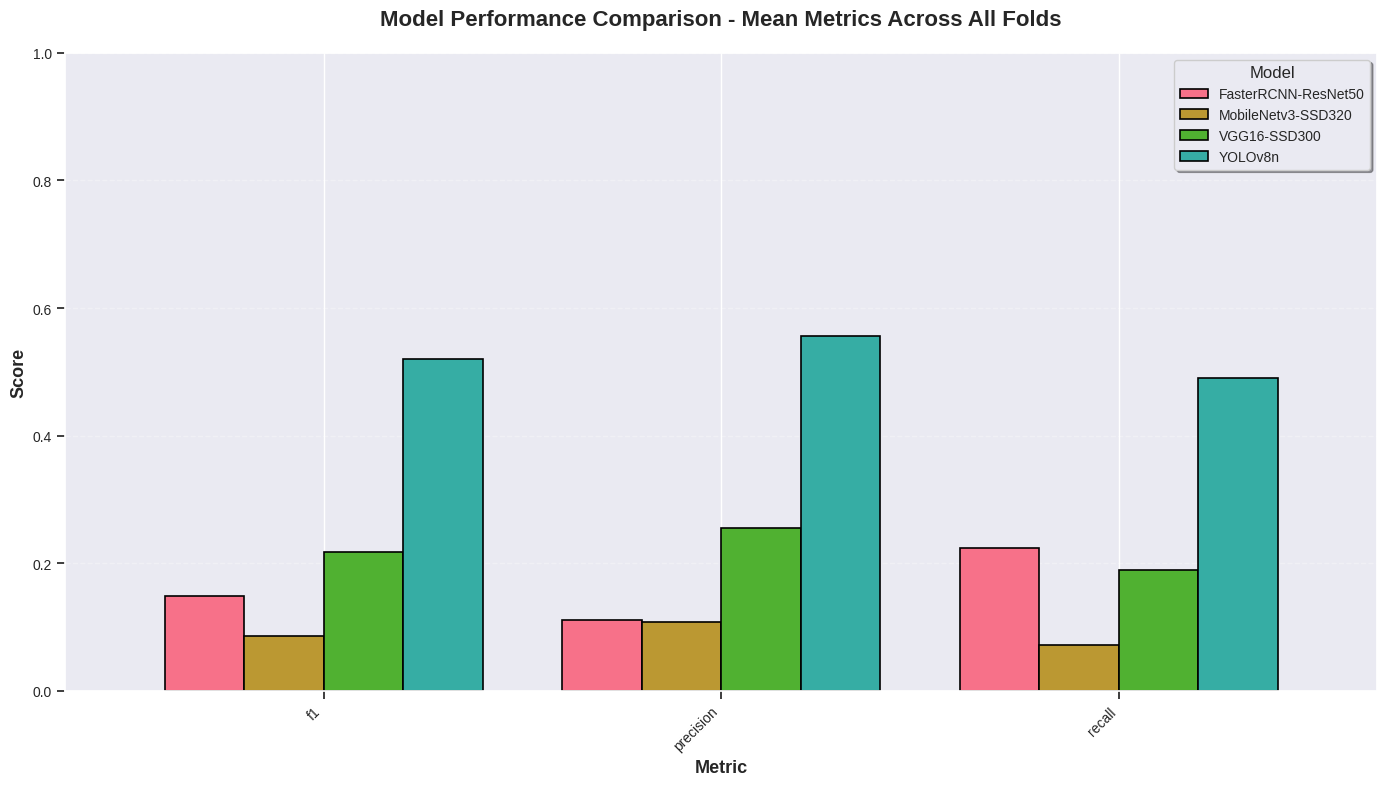

✅ Saved: 01_model_comparison_mean_metrics.png


In [10]:
### 6. Overall Model Comparison - Mean Performance

fig, ax = plt.subplots(figsize=(14, 8))

# Filter for mean metrics only
mean_metrics_df = df[df['class'] == 'mean'].copy()
metrics_to_plot = ['precision', 'recall', 'f1', 'ap50', 'ap', 'map']
mean_metrics_df = mean_metrics_df[mean_metrics_df['metric'].isin(metrics_to_plot)]

# Calculate mean across folds
plot_data = mean_metrics_df.groupby(['model', 'metric'])['value'].mean().reset_index()
plot_data_pivot = plot_data.pivot(index='metric', columns='model', values='value')

plot_data_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.2)

ax.set_title('Model Performance Comparison - Mean Metrics Across All Folds', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend(title='Model', title_fontsize=12, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / "01_model_comparison_mean_metrics.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 01_model_comparison_mean_metrics.png")

### 7. Heatmap - Model vs Metric Performance

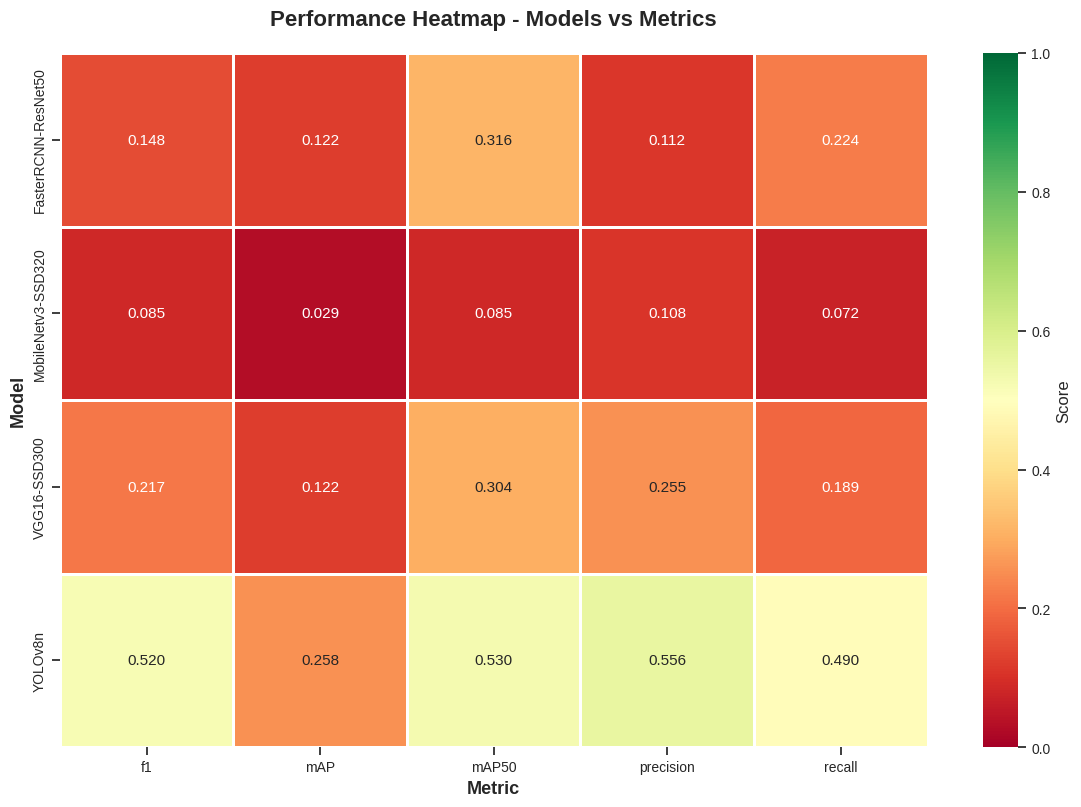

✅ Saved: 02_heatmap_model_metrics.png


In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

heatmap_data = df[df['class'] == 'mean'].groupby(['model', 'metric'])['value'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='model', columns='metric', values='value')

sns.heatmap(heatmap_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, ax=ax, linewidths=2, 
            vmin=0, vmax=1, square=True)

ax.set_title('Performance Heatmap - Models vs Metrics', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / "02_heatmap_model_metrics.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 02_heatmap_model_metrics.png")

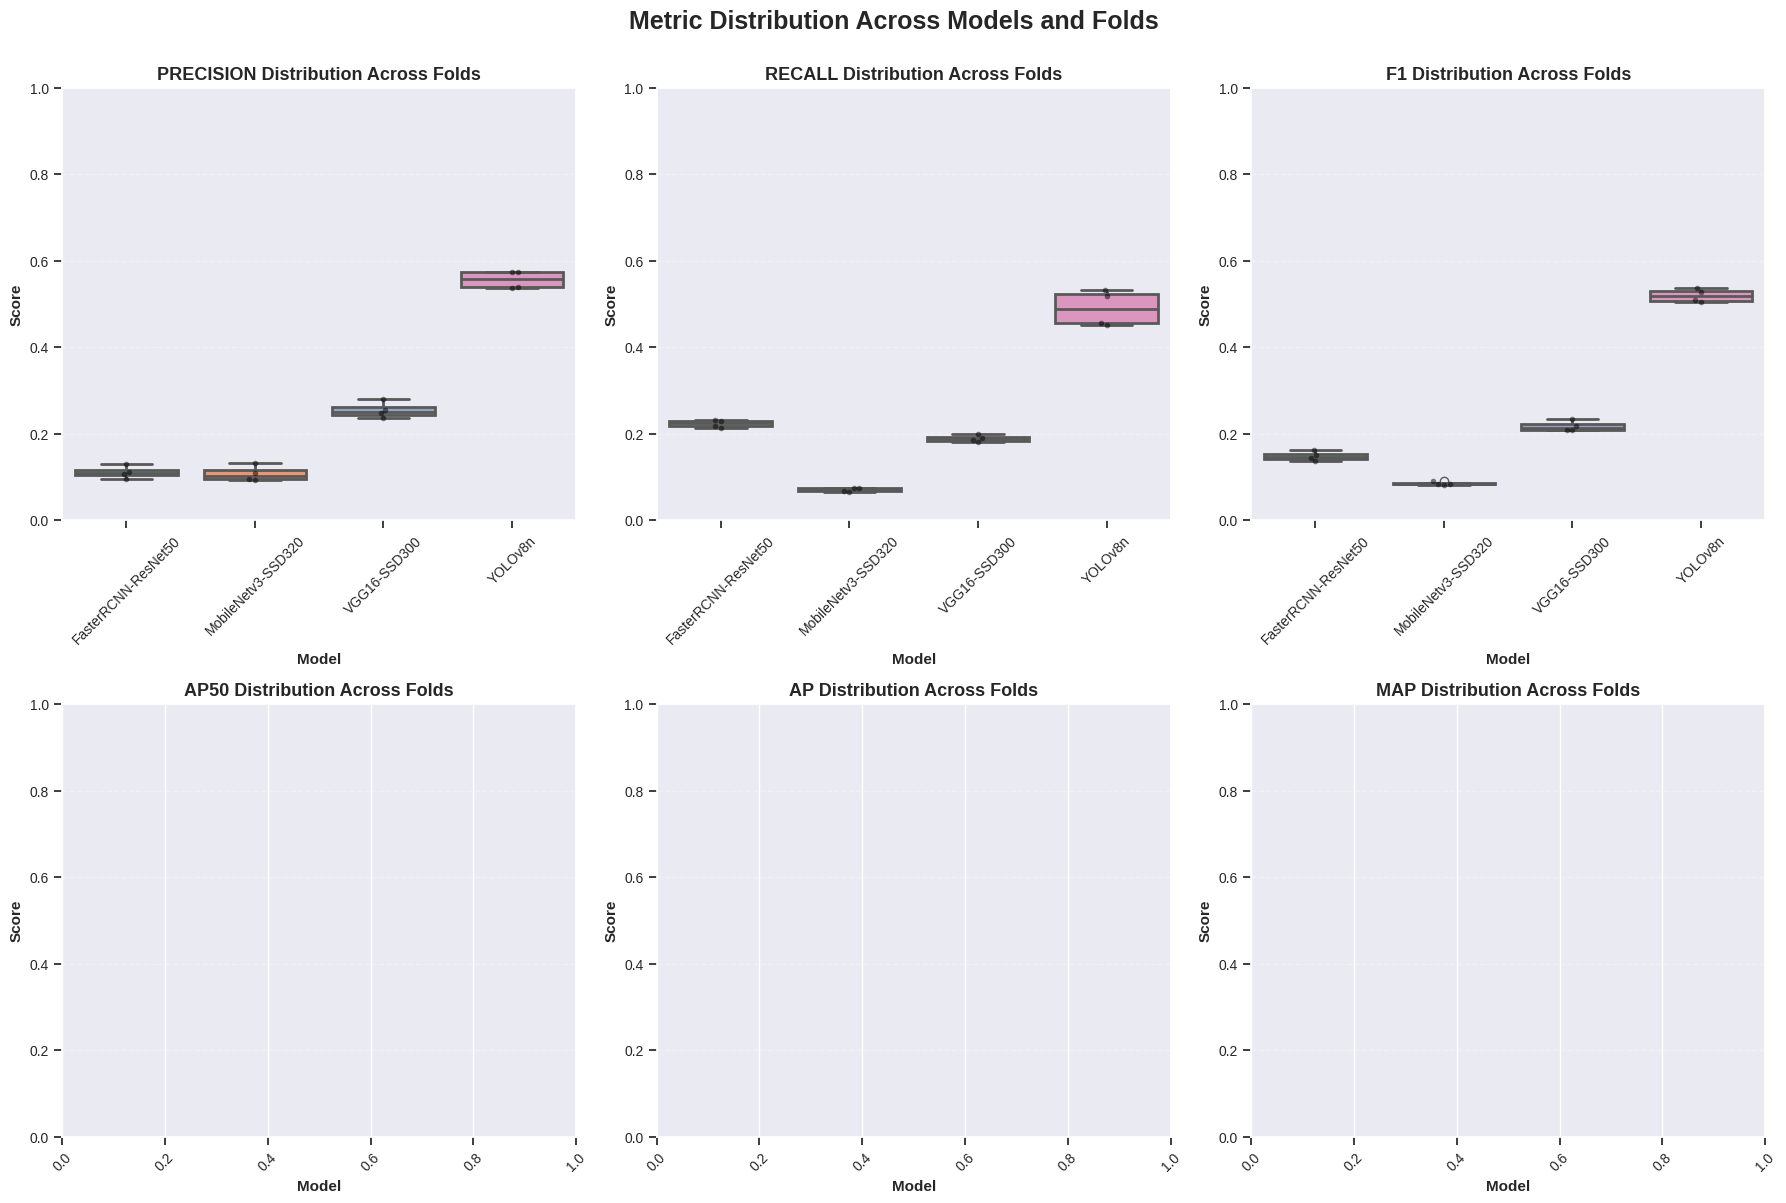

✅ Saved: 03_boxplot_fold_distribution.png


In [12]:
### 8. Box Plot - Distribution Across Folds

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_to_plot = ['precision', 'recall', 'f1', 'ap50', 'ap', 'map']
mean_data = df[df['class'] == 'mean'].copy()

for idx, metric in enumerate(metrics_to_plot):
    metric_data = mean_data[mean_data['metric'] == metric]
    
    sns.boxplot(data=metric_data, x='model', y='value', ax=axes[idx], 
                palette='Set2', linewidth=2)
    sns.swarmplot(data=metric_data, x='model', y='value', ax=axes[idx], 
                  color='black', alpha=0.5, size=4)
    
    axes[idx].set_title(f'{metric.upper()} Distribution Across Folds', 
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Metric Distribution Across Models and Folds', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(output_dir / "03_boxplot_fold_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 03_boxplot_fold_distribution.png")